In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"]="TRUE"
import pandas as pd
import pymoo
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.variable import Real, Integer, Binary, Choice
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
from autogluon.tabular import TabularDataset, TabularPredictor
import torch
import importlib
import numpy as np
from tqdm import trange,tqdm
import matplotlib.pyplot as plt 
import GA_Clip_utils
import datetime
import dill
import warnings
import glob
import textwrap
import imageio
import sys
sys.path.append("../../")
import calculate_dtai
import load_data
import multi_objective_cfe_generator as MOCG

/home/yazan/Repositories/Personal/Multiobjective-Counterfactuals-for-Design/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [2]:
importlib.reload(GA_Clip_utils)
importlib.reload(MOCG)
importlib.reload(calculate_dtai)

<module 'calculate_dtai' from '/home/mileva/Documents/Lyle/Counterfactuals-for-Design/CLIP_Testing/Functions/../../calculate_dtai.py'>

In [3]:
biked = pd.read_csv("../Data/clip_sBIKED_processed.csv", index_col=0)
dataset="clip_s"
embeddings = pd.read_csv("img_embeddings.csv", index_col=0)

In [4]:
display(biked)
print(embeddings)

CS textfield  BB textfield  Stack  Head angle  \
1           430.00     67.000000  565.6   73.000000   
2           350.00    -14.500000  565.6   71.500000   
3           415.00      4.000000  565.6   72.000000   
4           375.00     50.000000  565.6   70.500000   
5           431.79     24.000000  565.6   72.100000   
...            ...           ...    ...         ...   
4796        410.00     75.000000  552.0   72.500000   
4797        419.00     42.909345  598.9   65.772099   
4798        410.00    -11.500000  492.5   72.000000   
4799        410.00    -11.500000  500.0   72.000000   
4800        440.00     64.500000  565.6   73.500000   

      Head tube length textfield  Seat stay junction0  Seat tube length  \
1                          135.6                 45.0             588.7   
2                           80.0                 45.0             265.0   
3                          198.8                 45.0             562.0   
4                           91.8                 40.0             460.0   
5                           83.1                 41.0             300.0   
...                          ...                  ...               ...   
4796                       145.0                125.0             520.0   
4797                        95.0                 90.0             380.0   
4798                       250.0                 45.0             550.0   
4799                       280.4                 45.0             550.0   
4800                       145.7                 45.0             584.3   

      Seat angle   DT Length  BB diameter  ...  \
1      72.500000  664.020690         40.0  ...   
2      71.500000  572.491950         40.0  ...   
3      74.000000  647.103654         38.1  ...   
4      73.500000  573.904093         38.1  ...   
5      72.500000  636.179297         40.0  ...   
...          ...         ...          ...  ...   
4796   74.000000  644.551458         40.0  ...   
4797   77.772099  704.278730         40.0  ...   
4798   74.000000  547.934671         40.0  ...   
4799   74.000532  542.387502         40.0  ...   
4800   73.500000  659.573115         40.0  ...   

      bottle DOWNTUBE0 show OHCLASS: False  \
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   
5                                      1.0   
...                                    ...   
4796                                   0.0   
4797                                   1.0   
4798                                   0.0   
4799                                   0.0   
4800                                   1.0   

      bottle DOWNTUBE0 show OHCLASS: True  BELTorCHAIN OHCLASS: 0  \
1                                     0.0                     0.0   
2                                     0.0                     0.0   
3                                     0.0                     0.0   
4                                     0.0                     0.0   
5                                     0.0                     0.0   
...                                   ...                     ...   
4796                                  1.0                     0.0   
4797                                  0.0                     0.0   
4798                                  1.0                     0.0   
4799                                  1.0                     0.0   
4800                                  0.0                     0.0   

      BELTorCHAIN OHCLASS: 1  RIM_STYLE front OHCLASS: DISC  \
1                        1.0                            0.0   
2                        1.0                            0.0   
3                        1.0                            0.0   
4                        1.0                            0.0   
5                        1.0                            0.0   
...                      ...                            ...   
4796                

             0         1         2         3         4         5         6  \
1     0.306312  0.180333 -0.020206  0.067050 -0.106054 -0.567064 -0.040080   
2     0.087546  0.358816  0.173813 -0.047693 -0.150549 -0.560570 -0.001117   
3     0.158016  0.221164  0.130853 -0.037370 -0.108315 -0.571982  0.060196   
4     0.129044  0.188477  0.075373  0.146273 -0.100062 -0.509415 -0.099536   
5     0.061962  0.296279  0.150050 -0.002837 -0.180926 -0.539930 -0.034460   
...        ...       ...       ...       ...       ...       ...       ...   
4796  0.229417  0.293965  0.247105  0.025825 -0.151651 -0.639214  0.098681   
4797  0.087240  0.275428  0.084512  0.121780 -0.203518 -0.537219  0.020882   
4798  0.103718 -0.002238  0.341451 -0.115818  0.038240 -0.603683  0.247973   
4799  0.140885  0.166434  0.302694  0.001412  0.139113 -0.577181  0.289123   
4800  0.154538  0.280156 -0.007210  0.094436 -0.150637 -0.640680 -0.004233   

             7         8         9  ...       502       503    

In [5]:
device = "cuda"
model_id = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_id)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [6]:
prompt1 = "a futuristic black road racing bicycle"
# prompt2 = "an orange cyberpunk-style lowrider bike"
inputs1 = tokenizer(prompt1, return_tensors="pt").to(device)
target_embedding1 = model.get_text_features(**inputs1) #Our target text embedding
# inputs2 = tokenizer(prompt2, return_tensors="pt").to(device)
# target_embedding2 = model.get_text_features(**inputs2) #Our target text embedding

from PIL import Image
targetfile = "mtb.png"
img = Image.open(targetfile).convert("RGB")
width,height = img.size
img = img.resize((width//2, height//2))
result = Image.new(img.mode, (1300, 1300), (255,255,255))
result.paste(img, img.getbbox())
image = np.asarray(result)
img_processed = processor(text=None,images=image,return_tensors='pt')['pixel_values'].to(device)
target_embedding2 = model.get_image_features(img_processed)

In [7]:
a = torch.tensor(embeddings.values)
b1 = target_embedding1.cpu()
b2 = target_embedding2.cpu()
cos=torch.nn.CosineSimilarity()
res1 = cos(a,b1)
res1 = res1.detach().numpy()
res2 = cos(a,b2)
res2 = res2.detach().numpy()
targetval_1 = np.quantile(res1, 0.1) #select quantile here
targetval_2 = np.quantile(res2, 0.1) #select quantile here
scoredf1 = pd.DataFrame(res1, columns = ["O1"], index = embeddings.index)
scoredf2 = pd.DataFrame(res2, columns = ["O2"], index = embeddings.index)
allvals = pd.concat([biked, scoredf1, scoredf2], axis=1)
allvals.dropna(axis=0, inplace=True)

_, y_struct, _, xscaler = load_data.load_framed_dataset("r", onehot = True, scaled = True, augmented = True)
y_struct = y_struct.loc[:,["Sim 1 Safety Factor (Inverted)", "Model Mass Magnitude"]]
allvals.index = allvals.index.map(str)
commonidx = set(list(y_struct.index)).intersection(set(list(allvals.index)))

nunique = allvals.nunique()
cols_to_drop = nunique[nunique == 1].index
allvals = allvals.drop(cols_to_drop, axis=1)

allvals = pd.concat([allvals.loc[list(commonidx)], y_struct.loc[list(commonidx)]], axis=1)
predictor1 = TabularPredictor(label="Model Mass Magnitude").fit(train_data=allvals.drop(["O1", "O2", "Sim 1 Safety Factor (Inverted)"], axis=1))
predictor2 = TabularPredictor(label="Sim 1 Safety Factor (Inverted)").fit(train_data=allvals.drop(["O1", "O2", "Model Mass Magnitude"], axis=1))


No path specified. Models will be saved in: "AutogluonModels/ag-20230428_172511/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230428_172511/"
AutoGluon Version:  0.7.0
Python Version:     3.10.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #41~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Mar 31 16:00:14 UTC 2
Train Data Rows:    4046
Train Data Columns: 92
Label Column: Model Mass Magnitude
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (22.83, 0.83, 4.66102, 2.18426)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Mem

In [8]:
y = allvals.iloc[:,-4:]
x = allvals.iloc[:,:-4]
display(x)
display(y)

CS textfield  BB textfield  Stack  Head angle  \
924         376.92          42.0  565.6        75.5   
1051        447.00          50.0  565.6        70.5   
1653        405.00          57.0  565.6        72.0   
4800        440.00          64.5  565.6        73.5   
2417        355.00          35.0  565.6        73.0   
...            ...           ...    ...         ...   
1213        425.00          70.0  565.6        73.0   
2109        435.00          62.5  565.6        71.0   
1915        381.00           0.0  565.6        69.0   
301         450.00          53.0  565.6        70.0   
3442        515.00          35.0  565.6        65.0   

      Head tube length textfield  Seat stay junction0  Seat tube length  \
924                        117.6                100.0             545.9   
1051                       155.0                 45.0             543.4   
1653                       145.9                 65.0             599.7   
4800                       145.7                 45.0             584.3   
2417                       155.6                 45.0             528.2   
...                          ...                  ...               ...   
1213                       160.3                 95.0             615.5   
2109                       100.0                 38.0             520.7   
1915                       115.0                 60.0             307.0   
301                        196.0                 72.0             630.0   
3442                       117.0                 11.0             550.2   

      Seat angle   DT Length  BB diameter  ...  \
924         74.0  607.375211         40.0  ...   
1051        74.0  686.302078         40.0  ...   
1653        74.0  641.825355         40.0  ...   
4800        73.5  659.573115         40.0  ...   
2417        73.0  649.436254         40.0  ...   
...          ...         ...          ...  ...   
1213        73.0  651.179441         40.0  ...   
2109        75.0  641.345732         40.0  ...   
1915        70.0  606.350952         40.0  ...   
301         71.0  671.496269         35.0  ...   
3442        66.0  664.122869         45.5  ...   

      bottle DOWNTUBE0 show OHCLASS: False  \
924                                    1.0   
1051                                   1.0   
1653                                   1.0   
4800                                   1.0   
2417                                   1.0   
...                                    ...   
1213                                   0.0   
2109                                   1.0   
1915                                   1.0   
301                                    1.0   
3442                                   1.0   

      bottle DOWNTUBE0 show OHCLASS: True  BELTorCHAIN OHCLASS: 0  \
924                                   0.0                     0.0   
1051                                  0.0                     0.0   
1653                                  0.0                     0.0   
4800                                  0.0                     0.0   
2417                                  0.0                     0.0   
...                                   ...                     ...   
1213                                  1.0                     0.0   
2109                                  0.0                     1.0   
1915                                  0.0                     0.0   
301                                   0.0                     0.0   
3442                                  0.0                     0.0   

      BELTorCHAIN OHCLASS: 1  RIM_STYLE front OHCLASS: DISC  \
924                      1.0                            0.0   
1051                     1.0                            0.0   
1653                     1.0                            0.0   
4800                     1.0                            0.0   
2417                     1.0                            0.0   
...                      ...                            ...   
1213                

O1        O2  Sim 1 Safety Factor (Inverted)  Model Mass Magnitude
924   0.267204  0.834701                        1.184694                  2.97
1051  0.260838  0.878599                        0.911577                  3.37
1653  0.253312  0.847248                        2.421308                  5.66
4800  0.250309  0.852655                        6.849315                  3.44
2417  0.252103  0.868931                        0.744048                  5.05
...        ...       ...                             ...                   ...
1213  0.265773  0.840881                        2.205558                  8.25
2109  0.257842  0.850443                        2.420721                  4.10
1915  0.258971  0.873306                        1.165230                  4.84
301   0.262846  0.857070                        1.022913                  1.54
3442  0.260394  0.860447                        1.160362                  6.83

[4046 rows x 4 columns]

In [9]:
thread_count = GA_Clip_utils.init_mp()

CPU Thread Count: 24; reserving 2


100%|███████████████████████████████████████████| 22/22 [01:15<00:00,  3.44s/it]


In [23]:
def get_scores(valid_idxs, meanvals, pop_size):
    scores = np.full((pop_size, 2), 2.0) 
    for i in range(len(valid_idxs)):
        img_emb = meanvals[i]
        idx = valid_idxs[i]
        cos=torch.nn.CosineSimilarity()
        meanvals = meanvals.cpu()
        distance1 = cos(img_emb, target_embedding1.cpu())
        distance2 = cos(img_emb, target_embedding2.cpu())
        scores[idx,0] = 1-distance1.cpu().detach().numpy()
        scores[idx,1] = 1-distance2.cpu().detach().numpy()
    return scores
# def convertmats(x):
#     mats = x[["Material=Steel", "Material=Aluminum", "Material=Titanium"]].values
#     for i in range(len(x.index)):
#         if mats[i, 0]> mats[i, 1] and mats[i, 0]> mats[i, 2]:
#             mats[i,:] = (0.827145,-0.465079,-0.54407)
#         elif mats[i, 1]> mats[i, 2]:
#             mats[i,:] = (-1.208978,2.150174,-0.54407)
#         else:
#             mats[i,:] = (-1.208978,-0.465079,1.83800)
#         # mats[i,:] = (0.827145,-0.465079,-0.54407)
#     x.loc[:,["Material=Steel", "Material=Aluminum", "Material=Titanium"]] = mats
#     return x
class predictor_wrapper_class(object):
    def __init__(self, ref_columns, predictor1, predictor2):
        self.ref_columns = ref_columns
        self.predictor1=predictor1
        self.predictor2=predictor2
    def predict(self, x):
        x = pd.DataFrame(x, columns = self.ref_columns)
        # x = convertmats(x)
        valid_idxs, meanvals = GA_Clip_utils.get_mean_embedding(x, dataset, processor, model, thread_count, num_views=10)
        scores = get_scores(valid_idxs, meanvals, len(x.index))
        scores2 = self.predictor2.predict(x)
        scores3 = self.predictor1.predict(x)
        scores = np.concatenate([scores, np.expand_dims(scores2.values, axis=1), np.expand_dims(scores3.values, axis=1)], axis=1)
        scores = pd.DataFrame(scores, columns = y.columns)
        return scores
regressor = predictor_wrapper_class(x.columns, predictor1, predictor2) 

In [39]:
import data_package

query_y = {"O1": (0, 1-targetval_1),
           "O2": (0, 1-targetval_2),
    "Sim 1 Safety Factor (Inverted)": (0, 1),
           "Model Mass Magnitude": (0, 6)
          }
query_x = x.loc[["1"],]

ub = np.quantile(x.values, 0.99, axis=0)
lb = np.quantile(x.values, 0.01, axis=0)
datatypes=[]
for i in range(len(ub)):
    datatypes.append(Real(bounds=(lb[i], ub[i])))
vary = x.columns
dp = data_package.DataPackage(x, y, query_x, vary, query_y, datatypes)

In [40]:
bonus_objs = ["O1", "O2", "Sim 1 Safety Factor (Inverted)", "Model Mass Magnitude"]
# query_x = x.sample(1, axis=0)

problem = MOCG.MultiObjectiveCounterfactualsGenerator(dp, regressor, bonus_objs, [], datatypes)

In [46]:
cfset = MOCG.CFSet(problem, 1000, initialize_from_dataset=False)
cfset.optimize(800)
cfset.save("Checkpoints")

1.0 fraction valid
One-hot encoding 12 features
Onehot Completed in 0.017771005630493164 seconds
Loaded Imputed Dataframe in  0.01820063591003418 seconds
Number Files Being Handled: 1
Success in instance 0!
finished svg conversion
 Images loaded after 4.621670722961426 seconds
 View 0 batch 0 generated after 4.630784511566162 seconds
 View 0 batch 0 image features calculated after 4.672255039215088 seconds
Generating view 1 batch 0
 View 1 batch 0 generated after 4.6780476570129395 seconds
 View 1 batch 0 image features calculated after 4.7089762687683105 seconds
Generating view 2 batch 0
 View 2 batch 0 generated after 4.716267108917236 seconds
 View 2 batch 0 image features calculated after 4.789084196090698 seconds
Generating view 3 batch 0
 View 3 batch 0 generated after 4.796269178390503 seconds
 View 3 batch 0 image features calculated after 4.825414419174194 seconds
Generating view 4 batch 0
 View 4 batch 0 generated after 4.83351469039917 seconds
 View 4 batch 0 image features 

In [67]:
importlib.reload(GA_Clip_utils)
num_samples = 10
n = 6
cfs = [query_x]
perf = []
for i in range(n):
    o3 = 1.5**(n-1-i)
    o4 = 1.5**i
    for j in range(n):
        o1 = 2.5*2.5**(n-1-j)
        o2 = 2.5**j
        cfs.append(cfset.sample(1, 0.05, 0.05, 0.05, 0.05, np.array([0.75,0.15, 0.5, 1]), dtai_alpha = np.array([o1,o2,o3,o4]), include_dataset=False, num_dpp=2000))
        bestidx = np.argmin(cfset.agg_scores)
        perf.append(cfset.all_cf_y[bestidx])
cfs = pd.concat(cfs, axis=0)
valid_idxs, views_emb, views_processed, views_raw= GA_Clip_utils.get_clip_embedding_views(cfs, dataset, processor, model, thread_count, num_views=0, return_images=True)

Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning CFs
Scoring all counterfactual candidates!
Done! Returning C

In [68]:
print(len(views_raw))

37


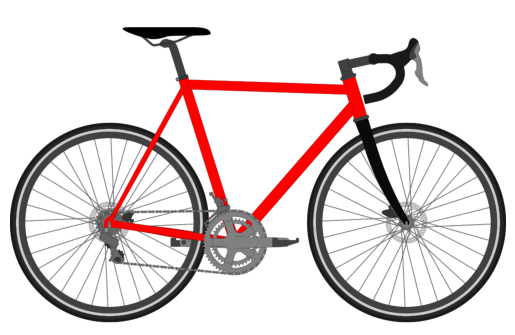

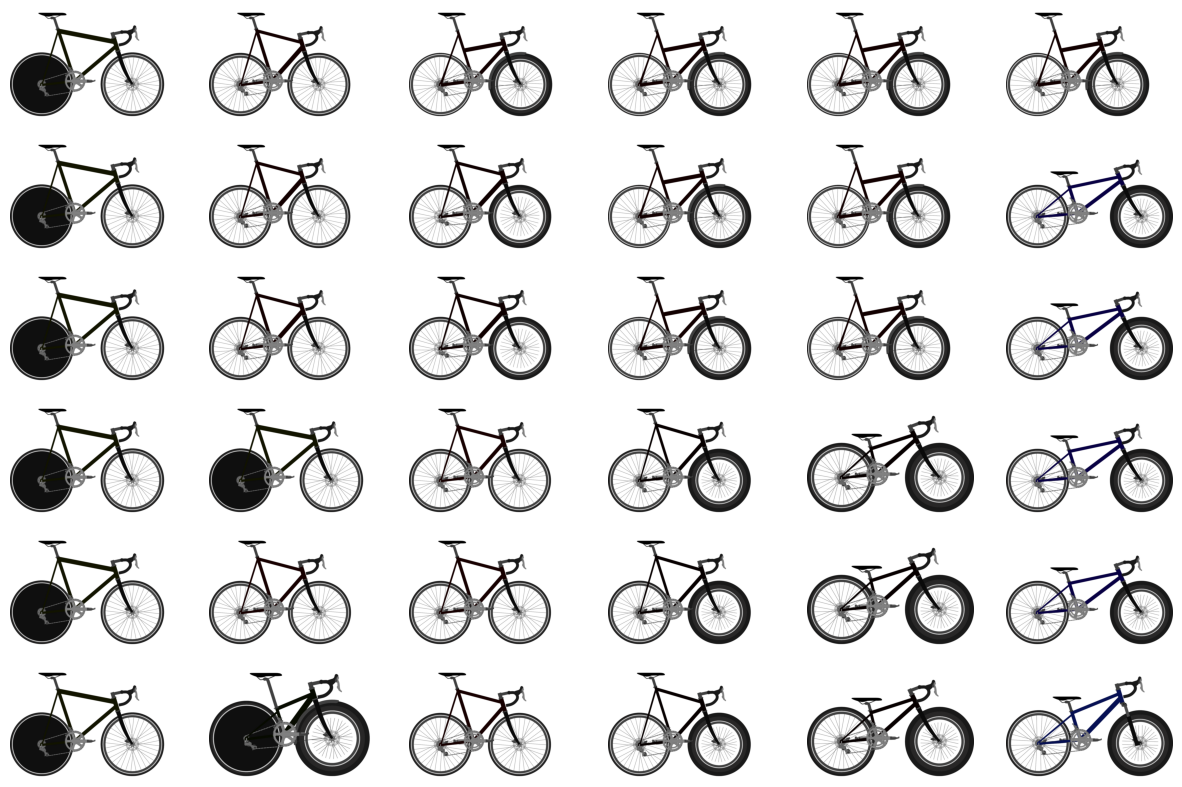

In [69]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
plt.imshow(views_raw[0].permute(1, 2, 0)[200:880])
plt.axis('off')
plt.savefig(f"Results/{timestr}_Query.png")
fig, axs = plt.subplots(n,n, figsize=(15,10))
for i in range(n):
    for j in range(n):
        ax = axs[i,j]
        ax.imshow(views_raw[j+i*n+1].permute(1, 2, 0)[190:880])
        ax.axis('off')
plt.savefig(f"Results/{timestr}_CFs.png")

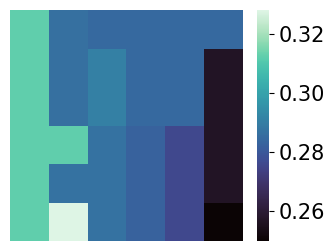

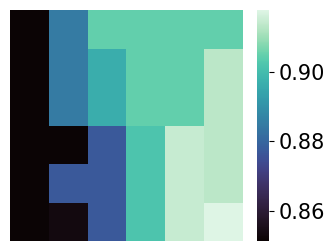

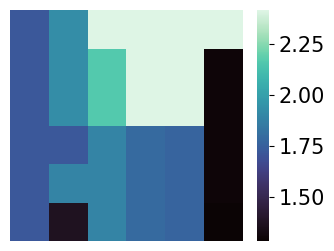

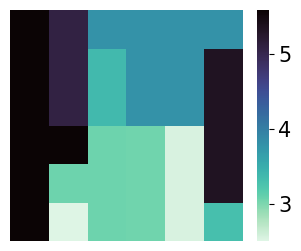

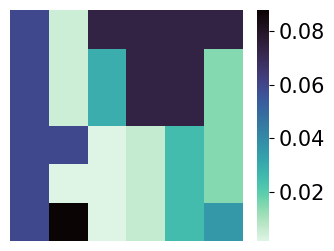

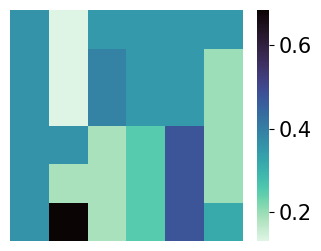

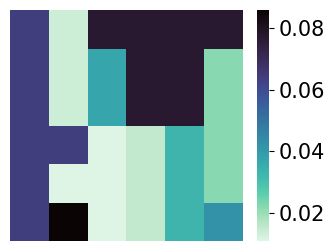

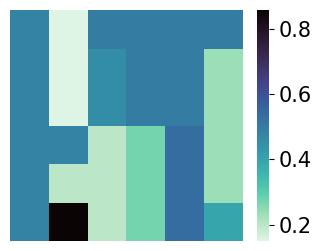

In [70]:
perf_stacked = np.vstack(perf)
import seaborn as sns
from textwrap import wrap
# titles=[f"Proximity to '{prompt1}'", f"Proximity to '{prompt2}'", "Gower Distance", "Changed Feature Ratio", "Average Gower Distance"]
for i in range(8):
    if not i==7:
        square = perf_stacked[:,i].reshape(n,n)
    fig, ax = plt.subplots(figsize=(3.75,3))
    if i in [0,1]:
        square = 1-square
        sns.heatmap(square, ax = ax, cmap = "mako")
    elif i==2:
        square = np.reciprocal(square)
        sns.heatmap(square, ax = ax, cmap = "mako")
    elif i==7:
        square = perf_stacked[:,4].reshape(n,n)+ perf_stacked[:,5].reshape(n,n) + perf_stacked[:,6].reshape(n,n)
        sns.heatmap(square, ax = ax, cmap = "mako_r")
    else:
        sns.heatmap(square, ax = ax, cmap = "mako_r")
    
    # plt.title("\n".join(wrap(titles[i], 28)), wrap=True)
    ax.axis('off')
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=15)
    plt.show()
    fig.savefig(f"Results/{timestr}_Heatmap_{i}.png")

In [ ]:
all_cfs = Population()
for algorithm in cfset.res.history:
    all_cfs = Population.merge(all_cfs, algorithm.off)

all_cf_x, all_cf_y = cfset.filter_by_validity(all_cfs)

In [ ]:
importlib.reload(GA_Clip_utils)
num_samples = 10
n = 6
cfs = [query_x]
for i in range(n):
    cf = 0.1/2**i
    gower = 0.1/2**i
    agower = 0.1/2**i
    o1 = 0.25*2**(n-1-i)
    o2 = 0
    cfs.append(cfset.sample(1, agower, cf, gower, 0.1, np.array([0.75,0.75]), dtai_alpha = np.array([o1,o2]), include_dataset=False, num_dpp=2000))
cfs = pd.concat(cfs, axis=0)
images_emb, images_processed, images_raw= GA_Clip_utils.get_clip_embedding(cfs, dataset, processor, model, thread_count, num_views=0)

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
# plt.imshow(images_raw[0].permute(1, 2, 0)[200:880])
# plt.axis('off')
# plt.savefig(f"Results/{timestr}_Query.png")
fig, axs = plt.subplots(n,1, figsize=(2,10))
for i in range(n):
    ax = axs[i]
    ax.imshow(images_raw[i].permute(1, 2, 0)[190:880])
    ax.axis('off')
plt.savefig(f"Results/{timestr}_CFs.png")

In [ ]:
importlib.reload(GA_Clip_utils)
num_samples = 10
n = 6
cfs = [query_x]
for i in range(n):
    cf = 0.1/2**i
    gower = 0.1/2**i
    agower = 1/2**i
    o1 = 0.25*2**(n-1-i)
    o2 = 0
    cfs.append(cfset.sample(3, agower, cf, gower, 0.05, np.array([0.75,0.75]), dtai_alpha = np.array([o1,o2]), include_dataset=False, num_dpp=2000))
cfs = pd.concat(cfs, axis=0)
images_emb, images_processed, images_raw= GA_Clip_utils.get_clip_embedding(cfs, dataset, processor, model, thread_count, num_views=0)

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
# plt.imshow(images_raw[0].permute(1, 2, 0)[200:880])
plt.axis('off')
plt.savefig(f"Results/{timestr}_Query.png")
fig, axs = plt.subplots(n,3, figsize=(15,10))
for i in range(n):
    for j in range(3):
        ax = axs[i,j]
        ax.imshow(images_raw[j+i*3+1].permute(1, 2, 0)[190:880])
        ax.axis('off')
plt.savefig(f"Results/{timestr}_CFs.png")